<a href="https://colab.research.google.com/github/SauravMaheshkar/SSL-Graphs/blob/add-grace/notebooks/GRACE/PyTorch_GRACE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [**Deep Graph Contrastive Representation Learning**](https://arxiv.org/abs/2006.04131v2)

By Yanqiao Zhu, Yichen Xu, Feng Yu, Qiang Liu, Shu Wu and Liang Wang

[Original Implementation](https://github.com/CRIPAC-DIG/GRACE)

# 📦 Packages and Basic Setup
---

In [1]:
# Install correct versions of PyTorch Geometric packages
!python -c "import torch; print(torch.__version__)"

!pip install torch-scatter -qq -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-sparse -qq -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-cluster -qq -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-spline-conv -qq -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -qq torch-geometric

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 51.4 MB/s 
     |████████████████████████████████| 3.5 MB 44.0 MB/s 
     |████████████████████████████████| 2.4 MB 27.6 MB/s 
     |████████████████████████████████| 709 kB 44.7 MB/s 
     |████████████████████████████████| 467 kB 24.1 MB/s 


In [2]:
import os
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from time import perf_counter as t
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.utils import dropout_adj
from torch_geometric.datasets import Planetoid, CitationFull

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### ⚙ Hyperparameters
---

In [ ]:
learning_rate = 0.0005
num_hidden = 128
num_proj_hidden = 128
activation = F.relu
base_model = GCNConv
num_layers = 2
drop_edge_rate_1 = 0.2
drop_edge_rate_2 = 0.4
drop_feature_rate_1 = 0.3
drop_feature_rate_2 = 0.4
tau = 0.4
num_epochs = 200
weight_decay = 0.00001

# 💿 Dataset
---

**Reported** Performance on Transductive Tasks for various datasets

| Method | Training Data | Cora     | Citeseer | Pubmed   | DBLP     |
|--------|---------------|----------|----------|----------|----------|
| GRACE  | X, A          | 83.3±0.4 | 72.1±0.5 | 86.7±0.1 | 84.2±0.1 |

In [3]:
%%capture
from torch_geometric.data import InMemoryDataset


def get_dataset(path: str, name: str = "Cora") -> InMemoryDataset:

    # Only Supports Cora, CiteSeer, PubMed and DBLP for now
    supported_datasets = ["Cora", "CiteSeer", "PubMed", "DBLP"]
    assert name in supported_datasets, "Invalid Dataset"

    return (CitationFull if name == "DBLP" else Planetoid)(
        root=path, name=name, transform=T.NormalizeFeatures()
    )


# Download Dataset
path = os.path.join(os.path.expanduser("~"), "datasets", "Cora")
dataset = get_dataset(path, "Cora")
data = dataset[0]
data = data.to(device)

### 👁 Visualize the dataset

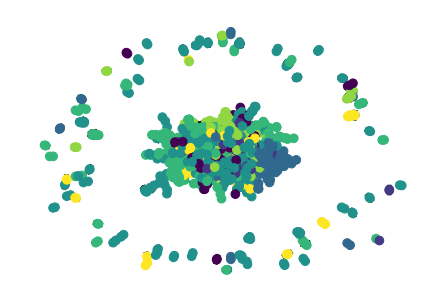

In [12]:
# Visualization code from https://discuss.pytorch.org/t/pytorch-geometric/44994/6
from torch_geometric.utils.convert import to_networkx

nx_graph = to_networkx(data)
node_labels = data.y[list(nx_graph.nodes)].cpu().numpy()
nx.draw(nx_graph, node_color = node_labels, node_size=75)

# ✍️ Model Architecture & Training
---

## Model
---

In the following cells, we implement the Encoder used to generate views and the Model we'll use. The two points of focus here are the two components of the overall loss objective 📉:-

1. Pairwise Objective for each positive pair $(u_i, v_i)$: (implemented in `semi_loss` and `batched_semi_loss`)

$$
\large
l(u_i, v_i) = \text{log} \frac{e^{\theta(u_i, v_i)/ \tau}}{{e^{\theta(u_i, v_i)/ \tau}} + \color{yellow}{\sum_{k=1}^{N}\mathbb{1}_{[k \neq 1]} e^{\theta(u_i, v_k)/ \tau}} + \color{green}{\sum_{k=1}^{N}\mathbb{1}_{[k \neq 1]} e^{\theta(u_i, u_k)/ \tau}}}
$$

2. Joint Training Objective $J$: (implemented in `loss`)

$$
\large
J = \frac{1}{2N} \sum_{i=1}^{N} \left[ l(u_i, v_i) + l(v_i, u_i) \right]
$$

In [ ]:
class Encoder(torch.nn.Module):
    """
    For more details refer to Section 4.2 of the paper
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        activation=F.relu,
        base_model=GCNConv,
        k: int = 2,
    ) -> None:
        super(Encoder, self).__init__()
        self.base_model = base_model

        # Build the Model
        assert k >= 2, f"k needs to be atleast 2"
        self.k = k
        self.conv = [base_model(in_channels, 2 * out_channels)]
        for _ in range(1, k - 1):
            self.conv.append(base_model(2 * out_channels, 2 * out_channels))
        self.conv.append(base_model(2 * out_channels, out_channels))
        self.conv = nn.ModuleList(self.conv)

        self.activation = activation

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """Compute a forward pass"""
        for i in range(self.k):
            x = self.activation(self.conv[i](x, edge_index))
        return x


class Model(torch.nn.Module):
    def __init__(
        self,
        encoder: torch.nn.Module,
        num_hidden: int,
        num_proj_hidden: int,
        tau: float = 0.5,
    ):
        super(Model, self).__init__()
        self.encoder = encoder
        self.tau = tau

        # To generate the projections, we use a two-layer MLP
        # For details, refer to section 3.2.1
        self.fc1 = torch.nn.Linear(num_hidden, num_proj_hidden)
        self.fc2 = torch.nn.Linear(num_proj_hidden, num_hidden)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """Compute a forward pass through the encoder"""
        return self.encoder(x, edge_index)

    def projection(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the projections for a given view,
        shown to enhance the expression power of the critic,
        For details, refer to Section 3.2.1
        """
        z = F.elu(self.fc1(z))
        return self.fc2(z)

    def cosine_sim(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        """
        Calculate the Cosine Similarity between two given views
        """
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)
        return torch.mm(z1, z2.t())

    def semi_loss(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        """
        Calculate the 'semi loss' between two given views
        """
        f = lambda x: torch.exp(x / self.tau)
        intraview_pairs = f(self.cosine_sim(z1, z1))
        interview_pairs = f(self.cosine_sim(z1, z2))

        return -torch.log(
            interview_pairs.diag()
            / (intraview_pairs.sum(1) + interview_pairs.sum(1) - intraview_pairs.diag())
        )

    def batched_semi_loss(
        self, z1: torch.Tensor, z2: torch.Tensor, batch_size: int
    ) -> torch.Tensor:
        """
        Calculate the `semi loss` between a batch of two given views
        Space complexity: O(BN) (semi_loss: O(N^2))
        """
        device = z1.device
        num_nodes = z1.size(0)
        num_batches = (num_nodes - 1) // batch_size + 1
        f = lambda x: torch.exp(x / self.tau)
        indices = torch.arange(0, num_nodes).to(device)
        losses = []

        for i in range(num_batches):
            # Mask out other values not in the current batch
            mask = indices[i * batch_size : (i + 1) * batch_size]

            # Similar to self.semi_loss()
            intraview_pairs = f(self.cosine_sim(z1[mask], z1))  # [B, N]
            interview_pairs = f(self.cosine_sim(z1[mask], z2))  # [B, N]

            losses.append(
                -torch.log(
                    interview_pairs[:, i * batch_size : (i + 1) * batch_size].diag()
                    / (
                        intraview_pairs.sum(1)
                        + interview_pairs.sum(1)
                        - intraview_pairs[
                            :, i * batch_size : (i + 1) * batch_size
                        ].diag()
                    )
                )
            )

        return torch.cat(losses)

    def loss(
        self, z1: torch.Tensor, z2: torch.Tensor, mean: bool = True, batch_size: int = 0
    ) -> torch.Tensor:
        """
        Overall objective for all positive pairs
        Eqn (2) from the paper
        """

        # ---- Generate views
        # one is used as the anchor
        # the other forms the positive sample
        u = self.projection(z1)
        v = self.projection(z2)

        # As the two views are symmetric
        # the other loss is just calculated
        # using alternate parameters

        if batch_size == 0:
            l1 = self.semi_loss(u, v)
            l2 = self.semi_loss(v, u)
        else:
            l1 = self.batched_semi_loss(u, v, batch_size)
            l2 = self.batched_semi_loss(v, u, batch_size)

        ret = (l1 + l2) * 0.5
        ret = ret.mean() if mean else ret.sum()

        return ret

In [ ]:
# Instantiate the Encoder and the Model
encoder = Encoder(
    in_channels=dataset.num_features,
    out_channels=num_hidden,
    activation=activation,
    base_model=base_model,
    k=num_layers,
).to(device)

model = Model(encoder, num_hidden, num_proj_hidden, tau).to(device)

## ⛑️ Utility Functions
---

In [ ]:
def drop_feature(x: torch.Tensor, drop_prob: float) -> torch.Tensor:
    """
    Implemention of Masking Node Features (MF) randomly masks
    a fraction of dimensions with zeros in node features
    """
    drop_mask = (
        torch.empty((x.size(1),), dtype=torch.float32, device=x.device).uniform_(0, 1)
        < drop_prob
    )
    x = x.clone()
    x[:, drop_mask] = 0

    return x


def train_step(model: torch.nn.Module, x: torch.Tensor, edge_index: torch.Tensor):
    optimizer.zero_grad()

    # Graph View Generation

    ## Removing Edges (RE)
    edge_index_1 = dropout_adj(edge_index, p=drop_edge_rate_1)[0]
    edge_index_2 = dropout_adj(edge_index, p=drop_edge_rate_2)[0]
    ## Masking Node Features (MF)
    x_1 = drop_feature(x, drop_feature_rate_1)
    x_2 = drop_feature(x, drop_feature_rate_2)
    ## Generating views
    z1 = model(x_1, edge_index_1)
    z2 = model(x_2, edge_index_2)

    # Calculate loss
    loss = model.loss(z1, z2, batch_size=0)

    # Perform Backprop
    loss.backward()
    optimizer.step()

    return loss.item()

## Let's train

In [ ]:
# create a optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

# Set the model into Training Mode
model.train()

# Run training
for epoch in range(1, num_epochs + 1):
    loss = train_step(model, data.x, data.edge_index)

    print(f"Epoch={epoch:03d} | loss={loss:.4f}")